# Flat Unrolled Cascade - Single-channel - Train

- Single-channel data
- Images are 256x256
- R=5 

In [1]:
%matplotlib inline
import matplotlib.pylab as plt
import numpy as np
import os
import glob
import sys

# Importing our model
MY_UTILS_PATH = "../Modules/"
if not MY_UTILS_PATH in sys.path:
    sys.path.append(MY_UTILS_PATH)
import cs_models_sc as fsnet

# Importing callbacks and data augmentation utils
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import  Adam

Using TensorFlow backend.


In [2]:
## PARAMETERS
H,W = 256,256 # Training image dimensions
channels = 2 # complex data 0-> real; 1-> imaginary
norm = np.sqrt(H*W)

# Train Set 
train_path = "/home/ubuntu/volume1/Raw-data/SC/Train/*.npy"
kspace_files_train = np.asarray(glob.glob(train_path))

# Validation set
val_path = "/home/ubuntu/volume1/Raw-data/SC/Val/*.npy"
kspace_files_val = np.asarray(glob.glob(val_path))

indexes = np.arange(kspace_files_train.size,dtype = int)
np.random.shuffle(indexes)
kspace_files_train = kspace_files_train[indexes]


print(kspace_files_train[-1])
print(len(kspace_files_train))

print(kspace_files_val[-1])
print(len(kspace_files_val))

/home/ubuntu/volume1/Raw-data/SC/Train/e13993s4_P16896.7.npy
25
/home/ubuntu/volume1/Raw-data/SC/Val/e14258s3_P76800.7.npy
10


In [3]:
# Get number of samples
ntrain = 0
for ii in range(len(kspace_files_train)):
    ntrain += np.load(kspace_files_train[ii]).shape[0] 

# Load train data    
rec_train = np.zeros((ntrain,H,W,2))

aux_counter = 0
for ii in range(len(kspace_files_train)):
     aux_kspace = np.load(kspace_files_train[ii])/norm
     aux = int(aux_kspace.shape[0])
     aux2 = np.fft.ifft2(aux_kspace[:,:,:,0]+\
                         1j*aux_kspace[:,:,:,1])
     rec_train[aux_counter:aux_counter+aux,:,:,0] = aux2.real
     rec_train[aux_counter:aux_counter+aux,:,:,1] = aux2.imag
     aux_counter+=aux

# Shuffle training    
indexes = np.arange(rec_train.shape[0],dtype = int)
np.random.shuffle(indexes)
rec_train = rec_train[indexes]
print("Number of training samples", rec_train.shape[0])

Number of training samples 4254


In [4]:
# Get number of samples
nval = 0
for ii in range(len(kspace_files_val)):
    nval += (np.load(kspace_files_val[ii]).shape[0] )

# Load Validation data
kspace_val = np.zeros((nval,H,W,2))
rec_val = np.zeros((nval,H,W,2))
aux_counter = 0
for ii in range(len(kspace_files_val)):
    aux_kspace = np.load(kspace_files_val[ii])/norm
    aux = int(aux_kspace.shape[0])
    kspace_val[aux_counter:aux_counter+aux] = aux_kspace
    aux2 = np.fft.ifft2(aux_kspace[:,:,:,0]+1j*aux_kspace[:,:,:,1])
    rec_val[aux_counter:aux_counter+aux,:,:,0] = aux2.real
    rec_val[aux_counter:aux_counter+aux,:,:,1] = aux2.imag
    aux_counter+=aux

print("Number of samples", kspace_val.shape[0])

Number of samples 1700


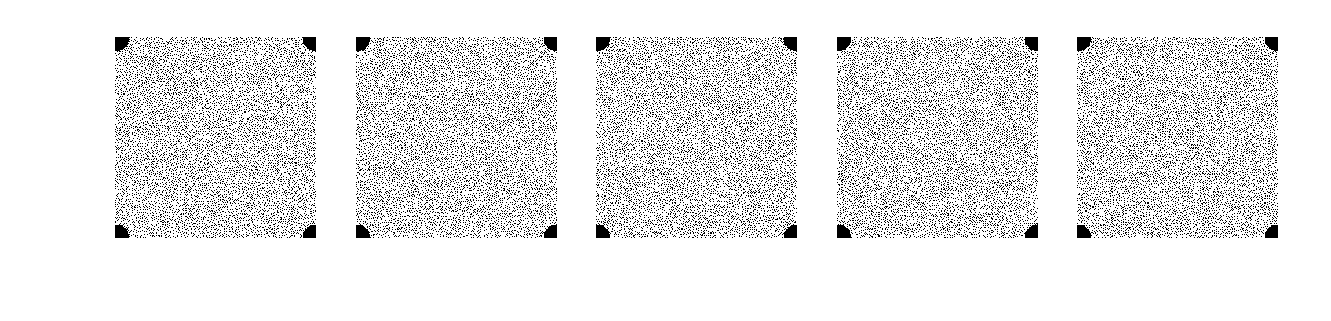

Undersampling: 0.801424560546875


In [5]:
# Loading sampling patterns. Notice that here we are using uncentred k-space
var_sampling_mask = np.fft.fftshift(~np.load("../Data/Sampling-patterns/256x256/poisson_center_radius=18_20perc.npy") \
                                    ,axes = (1,2))
var_sampling_mask = np.concatenate((var_sampling_mask[:,:,:,np.newaxis],var_sampling_mask[:,:,:,np.newaxis]),\
                                          axis = -1)


# White pixels are retrospectively discarded
plt.figure(dpi = 250)
for ii in range(5):
    plt.subplot(1,5,ii+1)
    plt.imshow(var_sampling_mask[ii*10,:,:,0],cmap = "gray")
    plt.axis("off")
plt.show()

print("Undersampling:", 1.0*var_sampling_mask.sum()/var_sampling_mask.size)

In [10]:
epochs = 100
batch_size= 6

model_name = "../Models/flat_unrolled_cascade_ikikii.hdf5"

# Early stopping callback to shut down training after
# 5 epochs with no improvement
earlyStopping = EarlyStopping(monitor='val_loss',
                                       patience=20, 
                                       verbose=0, mode='min')

# Checkpoint callback to save model  along the epochs
checkpoint = ModelCheckpoint(model_name, mode = 'min', \
                         monitor='val_loss',verbose=0,\
                         save_best_only=True, save_weights_only = True)

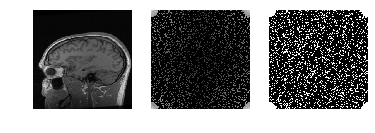

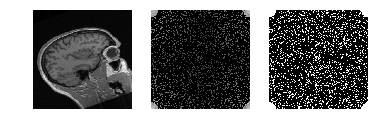

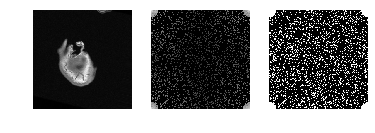

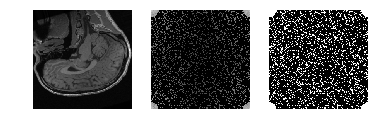

In [7]:
# On the fly data augmentation
def combine_generator(gen1,gen2,under_masks):
    while True:
        rec_real = gen1.next()
        rec_imag = gen2.next()
        kspace = np.fft.fft2(rec_real[:,:,:,0]+1j*rec_imag[:,:,:,0])
        kspace2 = np.zeros((kspace.shape[0],kspace.shape[1],kspace.shape[2],2))
        kspace2[:,:,:,0] = kspace.real
        kspace2[:,:,:,1] = kspace.imag
        indexes = np.random.choice(np.arange(under_masks.shape[0], dtype=int), rec_real.shape[0], replace=False)
        kspace2[under_masks[indexes]] = 0
        
        rec_complex = np.zeros((rec_real.shape[0],rec_real.shape[1],rec_real.shape[2],2),dtype = np.float32)
        rec_complex[:,:,:,0] = rec_real[:,:,:,0]
        rec_complex[:,:,:,1] = rec_imag[:,:,:,0]
        
        yield([kspace2,under_masks[indexes].astype(np.float32)],[rec_complex])
        
seed = 905
image_datagen1 = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.05,
    height_shift_range=0.05,
    shear_range=0.05,
    zoom_range=0.05,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest')

image_datagen2 = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.05,
    height_shift_range=0.05,
    shear_range=0.05,
    zoom_range=0.05,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest')


image_generator1 = image_datagen1.flow(rec_train[:,:,:,0,np.newaxis],batch_size = batch_size,seed = seed)
image_generator2 = image_datagen2.flow(rec_train[:,:,:,1,np.newaxis],batch_size = batch_size,seed = seed)        


combined = combine_generator(image_generator1,image_generator2, var_sampling_mask)

# Dispaly sample data augmentation
counter = 0
for ii in combined:
    plt.figure()
    plt.subplot(131)
    plt.imshow(np.abs(ii[1][0][4,:,:,0]+1j*ii[1][0][4,:,:,0]),cmap = 'gray')
    plt.axis("off")
    plt.subplot(132)
    plt.imshow(np.log(1+np.abs(ii[0][0][4,:,:,0] + 1j*ii[0][0][4,:,:,1])),cmap = 'gray')
    plt.axis("off")
    plt.subplot(133)
    plt.imshow(ii[0][0][4,:,:,0].astype(bool),cmap = 'gray')
    plt.axis("off")
    plt.show()
    counter+=1
    if counter > 3:
        break

In [8]:
# Undersampling the validation set
indexes = np.random.choice(np.arange(var_sampling_mask.shape[0],dtype =int),kspace_val.shape[0],replace = True)
val_var_sampling_mask = (var_sampling_mask[indexes])
kspace_val[val_var_sampling_mask] = 0

In [11]:
# Training our model
model = fsnet.deep_cascade_flat_unrolled("ikikii", H, W)
opt = Adam(lr = 1e-3,decay = 1e-4)
model.compile(loss = 'mse',optimizer=opt)
print(model.summary())

hist = model.fit_generator(combined,
             epochs=epochs,
             steps_per_epoch=rec_train.shape[0]//batch_size,
             verbose=1,
             validation_data= ([kspace_val,val_var_sampling_mask],[rec_val]),
             callbacks=[checkpoint,earlyStopping])

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/activations.py:211: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 256, 256, 2)  0                                            
__________________________________________________________________________________________________
lambda_46 (Lambda)              (None, 256, 256, 2)  0           input_3[0][0]                    
__________________________________________________________________________________________________
conv2d_37 (Conv2D)              (None, 256, 256, 48) 912         lambda_46[0][0]                  
__________________________________________________________________________________________________
conv2d_38 (Conv2D)              (None, 256, 256, 48) 20784       conv2d_37[0][0]                  
__________________________________________________________________________________________________
conv2d_39 

Epoch 1/100
709/709 [==============================] - 141s 199ms/step - loss: 0.0761 - val_loss: 0.0997
Epoch 2/100
709/709 [==============================] - 139s 196ms/step - loss: 0.0749 - val_loss: 0.1014
Epoch 3/100
709/709 [==============================] - 139s 196ms/step - loss: 0.0737 - val_loss: 0.1000
Epoch 4/100
709/709 [==============================] - 139s 197ms/step - loss: 0.0732 - val_loss: 0.1015
Epoch 5/100
709/709 [==============================] - 139s 197ms/step - loss: 0.0723 - val_loss: 0.1001
Epoch 6/100
709/709 [==============================] - 139s 197ms/step - loss: 0.0719 - val_loss: 0.0969
Epoch 7/100
709/709 [==============================] - 139s 197ms/step - loss: 0.0716 - val_loss: 0.0972
Epoch 8/100
709/709 [==============================] - 139s 196ms/step - loss: 0.0712 - val_loss: 0.0941
Epoch 9/100
709/709 [==============================] - 139s 197ms/step - loss: 0.0706 - val_loss: 0.0937
Epoch 10/100
709/709 [==============================] -